In [2]:
!pip install keras.layers.normalization

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://mirrors.bfsu.edu.cn/pypi/web/simple
ERROR: Could not find a version that satisfies the requirement keras.layers.normalization (from versions: none)
ERROR: No matching distribution found for keras.layers.normalization


In [2]:
import zipfile
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Dense, TimeDistributed, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, accuracy_score
import matplotlib.pyplot as plt


In [4]:
# Step 1: Unzip the ZIP files
zip_filenames = ['Dengue-4-sequences.zip', 'Ebola-sequences.zip', 'SARS-CoV-2-sequences.zip', 'hepatitis-C-3a-sequences.zip', 'influenza-A-sequences.zip', 'mers-sequences.zip']

for zip_filename in zip_filenames:
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall()

fasta_filenames = [filename[:-4] for filename in zip_filenames]

In [5]:
# Step 2: Apply k-mer encoding
def k_mer_enc(filename: str, k: int):
    with open(filename + '.fasta', 'r') as file:
        seqs = []
        seq = ""
        for line in file.readlines():
            if line.startswith('>'):
                if len(seq) > 0:
                    seqs.append(seq)
                    seq = ""
            else:
                seq += line.strip('\n')
        if len(seq) > 0:
            seqs.append(seq)

        print(f'The file {filename} has {len(seqs)} sequences.')

        encodings = []
        for seq in seqs:
            encoding = []
            code = 0
            for c in seq:
                code *= 4
                if c == 'A':
                    code += 0
                if c == 'C':
                    code += 1
                if c == 'G':
                    code += 2
                if c == 'T':
                    code += 3
                code %= 4 ** k
                encoding.append(code)
            assert len(seq) == len(encoding), 'Error: Unmatched number of characters!'
            encodings.append(encoding)
        assert len(seqs) == len(encodings), 'Error: Unmatched number of sequences!'

        with open(filename + '.pkl', 'wb') as pkfile:
            pickle.dump(encodings, pkfile)

filenames = ['Dengue-4-sequences', 'Ebola-sequences', 'hepatitis-C-3a-sequences',
             'influenza-A-sequences', 'mers-sequences', 'SARS-CoV-2-sequences']
for filename in filenames:
    k_mer_enc(filename, 4)


The file Dengue-4-sequences has 3587 sequences.
The file Ebola-sequences has 4001 sequences.
The file hepatitis-C-3a-sequences has 3331 sequences.
The file influenza-A-sequences has 3669 sequences.
The file mers-sequences has 1633 sequences.
The file SARS-CoV-2-sequences has 4752 sequences.


In [3]:
# Step 3: Load encoded sequences and labels
data = []
labels = []
for i, filename in enumerate(filenames):
    with open(filename + '.pkl', 'rb') as pkfile:
        encodings = pickle.load(pkfile)
        data.extend(encodings)
        labels.extend([i] * len(encodings))

NameError: name 'filenames' is not defined

In [7]:
# Step 4: Pad sequences to the same length
max_seq_length = max([len(seq) for seq in data])
padded_data = tf.keras.preprocessing.sequence.pad_sequences(data, maxlen=max_seq_length, padding='post')

In [8]:
# Step 5: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_data, labels, test_size=0.2, stratify=labels, random_state=42)
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [9]:
# Step 6: Reshape the data for ConvLSTM input
X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], 1, 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], 1, 1)

In [10]:
# Step 7: Create ConvLSTM model
from keras.layers import Flatten
def create_convlstm_model(input_shape, num_classes, learning_rate):
    model = Sequential([
        # ConvLSTM2D layer
        ConvLSTM2D(filters=64, kernel_size=(3, 1), activation='relu', padding='same', input_shape=input_shape, return_sequences=True),
        BatchNormalization(),

        # Second ConvLSTM2D layer
        ConvLSTM2D(filters=64, kernel_size=(3, 1), activation='relu', padding='same', return_sequences=True),
        BatchNormalization(),

        # TimeDistributed Flatten layer
        TimeDistributed(Flatten()),

        # Dense layer
        Dense(128, activation='relu'),
        Flatten(),  # r
        # Output layer
        Dense(num_classes, activation='softmax')
    ])

    # Create an Adam optimizer with the specified learning rate
    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [16]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [17]:
early_stop = EarlyStopping(
    monitor='val_loss',  
    patience=4,  
    verbose=1,  
    restore_best_weights=True,  
)

In [19]:
# Step 8: Instantiate and train the model
learning_rate = 0.00001  # Set your desired learning rate
input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2], X_train_reshaped.shape[3], X_train_reshaped.shape[4])
num_classes = np.unique(y_train).shape[0]
convlstm_model = create_convlstm_model(input_shape, num_classes, learning_rate)
history = convlstm_model.fit(X_train_reshaped, y_train_cat, epochs=20, batch_size=32, validation_split=0.2,callbacks=[early_stop])

Epoch 1/20
420/420 [==============================] - 208s 482ms/step - loss: 0.3552 - accuracy: 0.9204 - val_loss: 0.1644 - val_accuracy: 0.9443
Epoch 2/20
420/420 [==============================] - 200s 477ms/step - loss: 0.1409 - accuracy: 0.9662 - val_loss: 0.2091 - val_accuracy: 0.9601
Epoch 3/20
420/420 [==============================] - 207s 492ms/step - loss: 0.0756 - accuracy: 0.9807 - val_loss: 0.1109 - val_accuracy: 0.9741
Epoch 4/20
420/420 [==============================] - 210s 500ms/step - loss: 0.0331 - accuracy: 0.9902 - val_loss: 0.0610 - val_accuracy: 0.9842
Epoch 5/20
420/420 [==============================] - 209s 497ms/step - loss: 0.0376 - accuracy: 0.9896 - val_loss: 0.0997 - val_accuracy: 0.9723
Epoch 6/20
420/420 [==============================] - 210s 499ms/step - loss: 0.0208 - accuracy: 0.9937 - val_loss: 0.0699 - val_accuracy: 0.9824
Epoch 7/20
420/420 [==============================] - 207s 492ms/step - loss: 0.0114 - accuracy: 0.9961 - val_loss: 0.0540 -

In [22]:
convlstm_model.save('convlstm_model.h5')

OSError: [Errno 28] Can't close file (file write failed: time = Tue Apr 11 03:45:50 2023
, filename = 'convlstm_model.h5', file descriptor = 83, errno = 28, error message = 'No space left on device', buf = 0xb0f2ed90, total write size = 6144, bytes this sub-write = 6144, bytes actually written = 18446744073709551615, offset = 0)

In [23]:
# Step 9: Evaluate the model
test_loss, test_acc = convlstm_model.evaluate(X_test_reshaped, y_test_cat)
print(f'Test accuracy: {test_acc}')

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
132/132 [==============================] - 23s 173ms/step - loss: 0.0507 - accuracy: 0.9862
Test accuracy: 0.9861739873886108


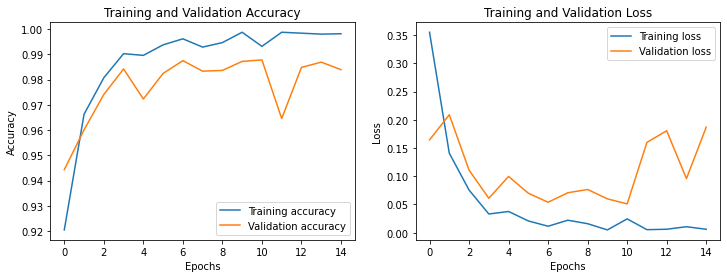

In [24]:
# Step 10: Plot training and validation accuracy and loss
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')

    plt.show()

plot_history(history)


In [25]:
# Step 11: Analyze model performance using classification metrics
y_pred = convlstm_model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_classes))
print('\nClassification Report:')
print(classification_report(y_test, y_pred_classes))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: [Errno 28] No space left on device
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: [Errno 28] No space left on device
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Confusion Matrix:
[[707   4   2   3   1   0]
 [  4 791   0   4   1   0]
 [  0   0 666   0   0   0]
 [ 11   0   0 723   0   0]
 [ 10   3   8   7 299   0]
 [  0   0   0   0   0 951]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       717
           1       0.99      0.99      0.99       800
           2       0.99      1.00      0

In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report

# One-hot encode the test labels
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

# Evaluate the model on the test data
test_loss, test_acc = convlstm_model.evaluate(X_test_reshaped, y_test_cat)

# Make predictions on the test data
y_pred_probs = convlstm_model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_probs, axis=1)



NameError: name 'keras' is not defined

In [ ]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)
conf_mat = confusion_matrix(y_test, y_pred)

# Calculate specificity (True Negative Rate) for each class
specificity = []
for i in range(num_classes):
    tn = conf_mat[i, i]
    fn = np.sum(conf_mat[:, i]) - tn
    specificity.append(tn / (tn + fn))



In [ ]:
# Calculate AUC score for each class
auc_scores = []
for i in range(num_classes):
    binary_y_true = (y_test == i).astype(int)
    binary_y_pred = y_pred_probs[:, i]
    auc = roc_auc_score(binary_y_true, binary_y_pred)
    auc_scores.append(auc)

print("Model Information:")
print(f"Embedding Dimension: {embedding_dim}")
print(f"Hidden Dimension: {hidden_dim}")
print(f"Output Dimension: {output_dim}")
print(f"No. of Layers: {num_layers}")
print(f"Dropout: {dropout}")
print(f"Optimizer: {optimizer}")
print(f"No. of Epochs: {num_epochs}")
print(f"Batch Size: {batch_size}")
print(f"Max Vocab Size: {max_vocab_size}")
print("\nEvaluation Metrics:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Acc: {test_acc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print("Precision: ", precision)
print("Recall: ", recall)
print("Specificity: ", specificity)
print("F1-score: ", f1)

print("\nAUC Scores:")

In [ ]:

for i in range(num_classes):
    print(f"Class {i} vs. Other Classes: {auc_scores[i]:.4f}")